__Regression of Air France Revenue:__

In [461]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorspacious import cspace_converter
from collections import OrderedDict
from matplotlib import cm
# Hierarchical CLustering of OECD Composite Indicator
# Import normalize
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pdb
mpl.rcParams['figure.figsize'] = 20, 5
mpl.rcParams['lines.linewidth'] = 2

In [462]:
mpl.rcParams['figure.figsize'] = 20, 5
mpl.rcParams['lines.linewidth'] = 2
df = pd.read_csv('regressmass.csv', parse_dates=['dates'], index_col='dates')
# df = df[df.applymap(np.isreal).any(1)]
df = df.interpolate().ffill().bfill().dropna()
df = df.select_dtypes(include=['float64', 'int64'])
# df= df.replace([np.inf, -np.inf], np.nan)
# df = df_model = df
df.pct_change().fillna(0)

,SALES_REV_TURN,FUEL_EXPENSES,IS_OPERATING_EXPN,IS_SELLING_EXPENSES,CF_DEPR_AMORT,ACCT_RCV_TURN,BS_ACCT_PAYABLE,EBIT,IS_INT_EXPENSE,BS_TOTAL_CAPITAL_LEASES,...,Maintenance,EBITDAR.2,Transavia.2,EBITDAR.3,Other,EBITDAR.4,Cargo,EBITDAR.5,Adjustments.1,Revenue.7
dates,,,,,,,,,,,,,,,,,,,,,
2002-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-09-30,-0.023831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-12-31,-0.030902,0.934844,0.969372,0.000000,1.082305,0.000000,-0.039942,-0.087838,0.740000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-31,-0.043367,0.000000,0.000000,0.000000,0.000000,0.000000,0.040091,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-06-30,0.003000,-0.515373,-0.515472,0.000000,-0.399209,0.000000,-0.074182,-1.096296,-0.597701,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30,0.141061,0.115928,0.048401,0.198276,-0.048714,-0.041469,0.049423,-3.212121,0.070175,-0.252509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-30,0.138868,0.163007,0.031949,-0.043165,0.005690,-0.020812,0.024333,1.972603,-0.032787,0.287325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,-0.133466,-0.029775,0.006811,-0.030075,0.041018,0.138578,-0.057471,-0.968664,-0.059322,-0.260117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [477]:
y_names = ['SALES_REV_TURN']

# df_model = df_model.drop(columns='Adj Close')
features_names_model = df_model.columns.drop(y_names).tolist()      

feature_target_df = df_model[y_names + features_names_model]

In [478]:
# Modification of features/target data properties (diff, shift, lag, etc..).
targets = feature_target_df[y_names]
features = feature_target_df[features_names_model]

In [465]:
def buildLaggedFeatures(s,lag=2,dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print ('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

features_lagged = buildLaggedFeatures(features, lag=10, dropna=True)
features = features_lagged

In [466]:
features['RANDOM'] = np.random.randint(3000,10000, features.shape[0])
features['RANDOM'].head()

dates
2004-12-31    8409
2005-03-31    3948
2005-06-30    6710
2005-09-30    3269
2005-12-31    4631
Name: RANDOM, dtype: int32

__Test-Train split__

In [479]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.60 * features.shape[0])
train_features = X = linear_features[:train_size]
train_targets  = Y = targets[:train_size]
test_features  = x = linear_features[train_size:]
test_targets   = y = targets[train_size:]

print(linear_features.shape, train_features.shape, test_features.shape)


(69, 359) (41, 359) (28, 359)


__Regression using Random Forest Regressor__

In [480]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=400)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(X, Y))
print(rfr.score(x, y))

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.9251176170346833
0.06415949728334525


Now with classic Random Forest Regressor we can extract features importances

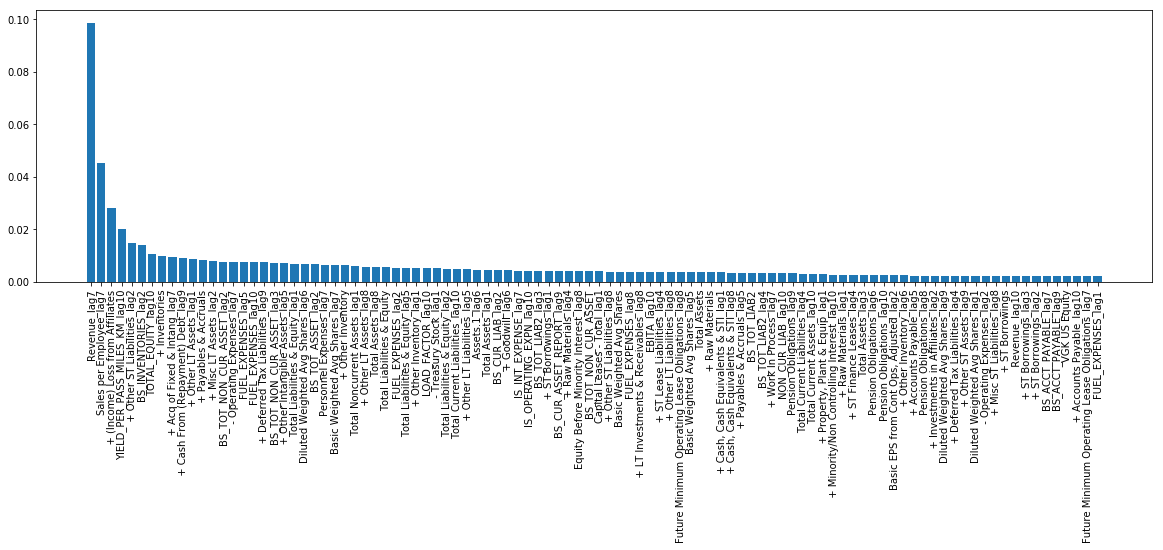

In [469]:
# Exrtract features importance with built-in function of random forest regressor
features_importances = rfr.feature_importances_

# Sort the index that will be our reference for the positino of each index regarding there importances
sorted_index = np.argsort(features_importances)[::-1][:100]

# Create the corresponding labels to importances position
features_count = range(len(sorted_index))
labels = np.array(linear_features.columns.to_list())[sorted_index]

def map_importance(model):
   
    # Plot the graph
    plt.bar(features_count, features_importances[sorted_index], tick_label=labels)
    plt.xticks(rotation=90)
    plt.show()

mpl.rcParams['figure.figsize'] = 20 , 5
map_importance(rfr)

In [470]:
features = X = features[labels]

In [471]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

calculate_vif_(features)

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'Revenue_lag7' at index: 0
dropping 'Sales per Employee_lag7' at index: 0
dropping '    + (Income) Loss from Affiliates' at index: 0
dropping 'YIELD_PER_PASS_MILES_KM_lag10' at index: 0
dropping '  + Other ST Liabilities_lag2' at index: 0
dropping 'BS_INVENTORIES_lag2' at index: 0
dropping 'TOTAL_EQUITY_lag10' at index: 0
dropping '  + Inventories' at index: 0
dropping '    + Acq of Fixed & Intang_lag7' at index: 0
dropping '  + Cash From (Repayment) Debt_lag9' at index: 0
dropping '  + Other LT Assets_lag1' at index: 0
dropping '  + Payables & Accruals' at index: 0
dropping '    + Misc LT Assets_lag2' at index: 0
dropping 'BS_TOT_NON_CUR_ASSET_lag2' at index: 0
dropping '  - Operating Expenses_lag7' at index: 0
dropping 'FUEL_EXPENSES_lag5' at index: 0
dropping 'FUEL_EXPENSES_lag10' at index: 0
dropping '    + Deferred Tax Liabilities_lag9' at index: 0
dropping 'BS_TOT_NON_CUR_ASSET_lag3' at index: 0
dropping '    + Other Intangible Assets_lag5' at index: 0
dropping 'Total Li

,+ Goodwill_lag6,IS_INT_EXPENSE_lag7,IS_OPERATING_EXPN_lag10,+ ST Borrowings_lag1,Equity Before Minority Interest_lag8,+ LT Investments & Receivables_lag8,+ ST Lease Liabilities_lag4,+ Other LT Liabilities_lag8,Basic Weighted Avg Shares_lag5,+ Work In Process_lag7,...,Pension Obligations_lag8,+ Investments in Affiliates_lag2,+ Deferred Tax Liabilities_lag4,+ Other ST Assets_lag9,Diluted Weighted Avg Shares_lag1,+ Misc ST Liabilities_lag8,+ ST Borrowings,+ ST Borrowings_lag3,+ ST Borrowings_lag2,Future Minimum Operating Lease Obligations_lag7
dates,,,,,,,,,,,,,,,,,,,,,
2004-12-31,115.0,87.0,3167.0,862.00,4112.0,236.0,444.00,949.0,216.41100,52.00,...,581.00,546.0,313.000000,728.0,256.834000,2373.0,862.00,862.00,862.00,2359.00
2005-03-31,112.0,35.0,3167.0,862.00,4114.5,240.5,444.00,956.0,214.75700,52.00,...,581.00,336.0,313.000000,728.0,216.951700,2151.5,862.00,862.00,862.00,2359.00
2005-06-30,107.0,41.0,6237.0,862.00,4117.0,245.0,444.00,963.0,215.83325,52.00,...,581.00,443.0,313.000000,696.0,259.450000,1930.0,862.00,862.00,862.00,2359.00
2005-09-30,97.0,48.0,6237.0,862.00,3994.0,260.0,444.00,1095.0,216.90950,39.75,...,581.00,550.0,313.000000,664.0,287.346700,1964.0,862.00,862.00,862.00,2341.00
2005-12-31,87.0,25.0,3022.0,862.00,3992.0,257.0,444.00,1460.0,256.83400,27.50,...,594.75,546.0,313.000000,703.0,274.823350,2241.0,796.25,862.00,862.00,2323.00
2006-03-31,95.0,25.0,3088.0,796.25,4575.0,349.0,444.00,1825.0,216.95170,15.25,...,608.50,577.0,313.000000,748.0,262.300000,2815.5,730.50,862.00,862.00,2305.00
2006-06-30,93.0,25.0,7804.0,730.50,5158.0,441.0,444.00,2190.0,259.45000,3.00,...,622.25,584.0,313.000000,1229.5,260.460000,3390.0,664.75,862.00,796.25,2287.00
2006-09-30,91.0,79.0,3032.0,664.75,4062.0,268.0,444.00,1039.0,250.33000,16.00,...,636.00,192.0,313.000000,1711.0,282.261433,2229.0,599.00,796.25,730.50,2733.00
2006-12-31,87.0,91.0,4271.0,599.00,4565.0,289.5,523.75,1632.0,260.00000,29.00,...,721.00,196.0,559.000000,595.0,304.062867,3046.0,592.75,730.50,664.75,3179.00


In [472]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.60 * features.shape[0])
train_features = X = linear_features[:train_size]
train_targets  = Y = targets[:train_size]
test_features  = x = linear_features[train_size:]
test_targets   = y = targets[train_size:]

print(linear_features.shape, train_features.shape, test_features.shape)

(59, 101) (35, 101) (24, 101)


In [473]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=400)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(X, Y))
print(rfr.score(x, y))

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.9461444220528674


ValueError: Found input variables with inconsistent numbers of samples: [34, 24]

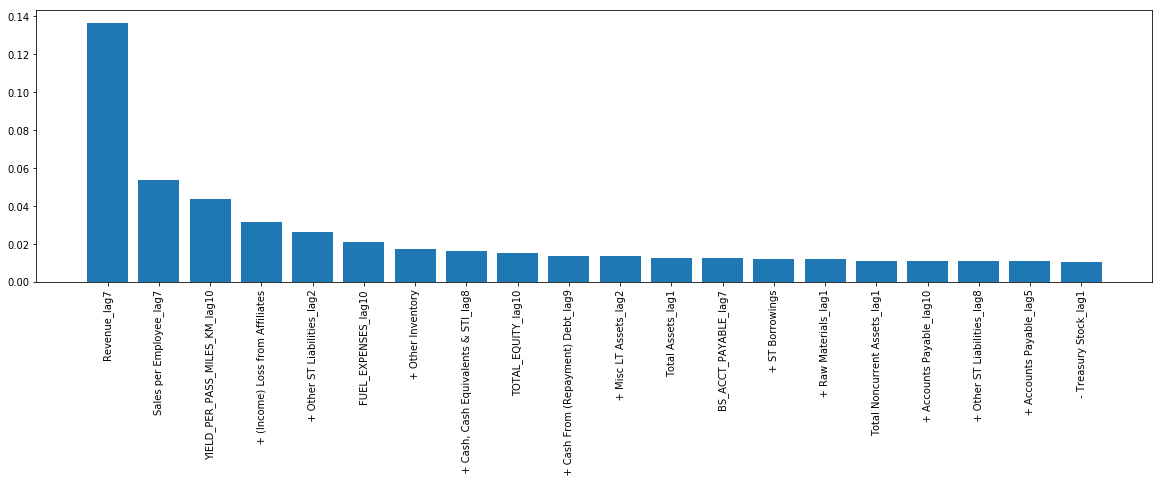

In [476]:
# Exrtract features importance with built-in function of random forest regressor
features_importances = rfr.feature_importances_

# Sort the index that will be our reference for the positino of each index regarding there importances
sorted_index = np.argsort(features_importances)[::-1][:20]

# Create the corresponding labels to importances position
features_count = range(len(sorted_index))
labels = np.array(linear_features.columns.to_list())[sorted_index] 

mpl.rcParams['figure.figsize'] = 20 , 5
map_importance(rfr)

__Let's play with parameter tuning using gridsearch cross validation__

In [436]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, Y):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(2,5),
            'n_estimators': (10, 50, 100, 200, 400, 600)},
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, Y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_absolute_error')

    return scores

rfr_model(X,Y)

ValueError: Found input variables with inconsistent numbers of samples: [69, 41]

In [392]:
scores = cross_val_score(rfr, x, y.values.ravel(), cv=10, scoring='neg_mean_absolute_error')

ValueError: Found input variables with inconsistent numbers of samples: [25, 33]

In [393]:
predictions = cross_val_predict(rfr, x, y.values.ravel(), cv=10)

ValueError: Found input variables with inconsistent numbers of samples: [25, 33]

In [394]:
def vizualize_model(model, test_targets):
    predictions = cross_val_predict(model, x, y.values.ravel(), cv=10)
    scores = cross_val_score(model, x, y.values.ravel(), cv=10, scoring='neg_mean_absolute_error')
    y_variables = y.values.tolist()
    
    plt.plot(predictions, 'g', y_variables, 'r')
    labels = ['predictions using Random Forest model', y_names]
    plt.legend(labels)
    
    #Print results & comments
    print('Mean Y: ', np.mean(y_variables).round(4))
    print('Mean predictions: ', np.mean(predictions).round(4))
    print('Score of model in sample:', model.score(X, Y).round(4))
    print('Score of model out-of-sample:',model.score(x, y).round(4))

vizualize_model(rfr, y)

ValueError: Found input variables with inconsistent numbers of samples: [25, 33]

__Gradient Boosting Regressor:__

https://campus.datacamp.com/courses/machine-learning-for-finance-in-python/machine-learning-tree-methods?ex=13

In [395]:
from sklearn.ensemble import GradientBoostingRegressor

gsc = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid={
        'max_depth': range(2,4),
        'n_estimators': (200, 400, 600),#, 200, 400, 600),
        'learning_rate': (0.2, 0.1, 0.05),#0.04, 0.03, 0.02, 0.01, 0.005),
        'subsample': (0.3, 0.4, 0.5),#,0.6, 0.7),
        'min_samples_split': (5, 4, 3, 2),#
        'random_state': (42, 80),#
        'loss': ('ls', 'huber', 'quantile', 'lad')},
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_

gbr = GradientBoostingRegressor(max_depth         = best_params["max_depth"],
                                n_estimators      = best_params["n_estimators"],
                                learning_rate     = best_params["learning_rate"],
                                subsample         = best_params["subsample"],
                                min_samples_split = best_params["min_samples_split"],
                                random_state      = best_params["random_state"],
                                loss              = best_params["loss"],
                                verbose=False)

scores = cross_val_score(gbr, X, y, cv=10, scoring='neg_mean_absolute_error')

# Perform K-Fold CV
gbr.fit(X,Y)

print(gbr.score(X, Y))
print(gbr.score(x, y))

ValueError: Found input variables with inconsistent numbers of samples: [61, 36]

In [396]:
grid_result.cv_results_

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.

{'mean_fit_time': array([0.08297763, 0.08995838, 0.09235249, ..., 0.32532973, 0.38197842,
        0.43581872]),
 'std_fit_time': array([0.00837988, 0.00521637, 0.00173941, ..., 0.01037233, 0.01654509,
        0.00328324]),
 'mean_score_time': array([0.00139537, 0.0011971 , 0.00119729, ..., 0.00159645, 0.00179567,
        0.0009974 ]),
 'std_score_time': array([0.00048733, 0.00039911, 0.00039878, ..., 0.00048852, 0.00074614,
        0.00089207]),
 'param_learning_rate': masked_array(data=[0.2, 0.2, 0.2, ..., 0.05, 0.05, 0.05],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_loss': masked_array(data=['ls', 'ls', 'ls', ..., 'lad', 'lad', 'lad'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 2, 2, ..., 3, 3, 3],
              mask=[False, False, False, ..., False, False, False],
        fill_value

In [397]:
gbr = GradientBoostingRegressor(
    loss='ls',
    learning_rate=0.01,
    n_estimators=400,
    subsample=0.6,
    criterion='friedman_mse',
    min_samples_split=5,
    min_samples_leaf=4,
    min_weight_fraction_leaf=0.,
    max_depth=3,
    min_impurity_decrease=0.1,
    min_impurity_split=None,
    init=None,
    random_state=60,
    max_features=20,
    alpha=0.8,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='auto',
    validation_fraction=0.01,
    n_iter_no_change=None,
    tol=0.001)

gbr.fit(X,Y)
print(gbr.score(X, Y))
print(gbr.score(x, y))

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Found input variables with inconsistent numbers of samples: [61, 36]

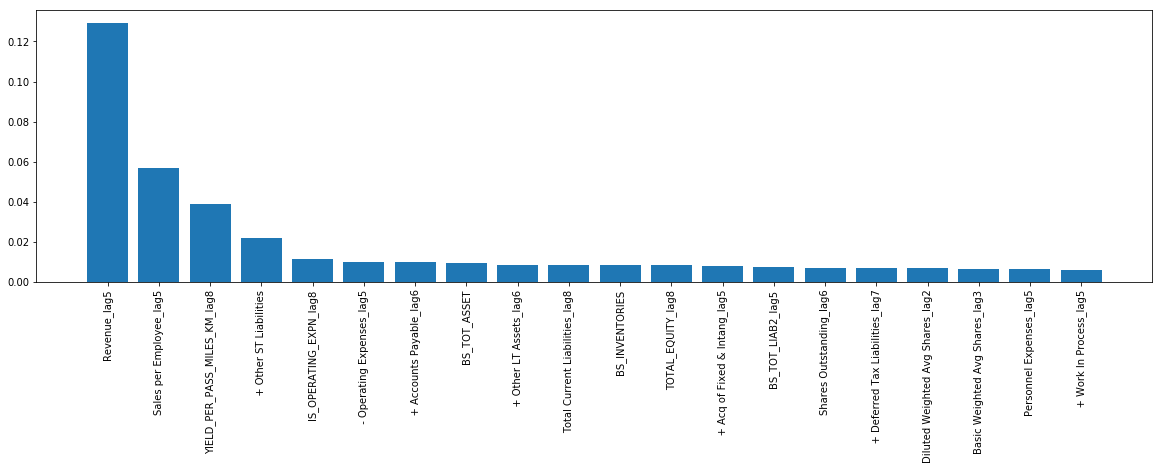

In [398]:
map_importance(gbr)

In [399]:
vizualize_model(gbr, y)

ValueError: Found input variables with inconsistent numbers of samples: [25, 33]